In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import itertools
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Input, UpSampling2D, Dropout)
from tensorflow.keras.preprocessing.image import img_to_array
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from tensorflow import keras
from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    precision_recall_curve, auc, roc_auc_score, classification_report)

In [2]:
df = pd.read_csv('diabetes_ds.csv')

In [3]:
 #split data
training, cv, test = \
              np.split(df.sample(frac=1, random_state=721), 
                       [int(.6*len(df)), int(.8*len(df))])

In [4]:
training['train_test'] = 1
cv['train_test'] = 0
test['train_test'] = 0


%matplotlib inline
training.columns

Index(['Age', 'Gender', 'BMI', 'SBP', 'DBP', 'FPG', 'Chol', 'Tri', 'HDL',
       'LDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'smoking', 'drinking',
       'family_histroy', 'Diabetes', 'train_test'],
      dtype='object')

In [5]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2581 entries, 1907 to 3771
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             2581 non-null   int64  
 1   Gender          2581 non-null   int64  
 2   BMI             2581 non-null   float64
 3   SBP             2581 non-null   int64  
 4   DBP             2581 non-null   int64  
 5   FPG             2581 non-null   float64
 6   Chol            2581 non-null   float64
 7   Tri             2581 non-null   float64
 8   HDL             2581 non-null   float64
 9   LDL             2581 non-null   float64
 10  ALT             2581 non-null   float64
 11  BUN             2581 non-null   float64
 12  CCR             2581 non-null   float64
 13  FFPG            2581 non-null   float64
 14  smoking         2581 non-null   float64
 15  drinking        2581 non-null   float64
 16  family_histroy  2581 non-null   int64  
 17  Diabetes        2581 non-null   int

In [6]:
training.describe()

,Age,Gender,BMI,SBP,DBP,FPG,Chol,Tri,HDL,LDL,ALT,BUN,CCR,FFPG,smoking,drinking,family_histroy,Diabetes,train_test
count,2581.000000,2581.000000,2581.000000,2581.000000,2581.000000,2581.000000,2581.00000,2581.000000,2581.000000,2581.000000,2581.000000,2581.000000,2581.000000,2581.000000,2581.000000,2581.000000,2581.000000,2581.000000,2581.0
mean,47.991476,1.348702,24.129729,123.074390,76.263076,5.207935,4.86406,1.581243,1.660005,2.974635,26.271873,4.853301,71.678345,5.724587,2.976414,3.189122,0.063929,0.294847,1.0
std,14.813620,0.476652,3.403819,17.206089,10.816445,0.778859,0.90728,1.179149,1.067998,0.878647,21.516409,1.269605,17.479314,1.498640,1.195749,0.928667,0.244673,0.456062,0.0
min,22.000000,1.000000,15.600000,77.000000,47.000000,2.840000,2.21000,0.000000,0.000000,1.000000,4.500000,1.950000,4.860753,3.200000,1.000000,1.000000,0.000000,0.000000,1.0
25%,35.000000,1.000000,21.700000,111.000000,69.000000,4.700000,4.21000,0.860000,1.140000,2.350000,14.200000,3.990000,60.200000,4.900000,3.000000,3.000000,0.000000,0.000000,1.0
50%,46.000000,1.000000,24.000000,122.000000,76.000000,5.120000,4.80000,1.280000,1.340000,2.820000,20.000000,4.760000,72.100000,5.300000,3.000000,3.000000,0.000000,0.000000,1.0
75%,60.000000,2.000000,26.300000,134.000000,83.000000,5.700000,5.44000,1.940000,1.610000,3.410000,30.700000,5.560000,82.400000,6.000000,3.000000,3.000000,0.000000,1.000000,1.0
max,91.000000,2.000000,38.700000,189.000000,120.000000,6.990000,9.28000,14.930000,4.860753,5.580000,279.200000,17.730000,307.000000,29.700000,4.860753,4.860753,1.000000,1.000000,1.0


In [7]:
df_num = training[['Age', 'BMI', 'SBP', 'DBP', 
                  'FPG', 'Chol', 'Tri', 'HDL',
                  'LDL', 'ALT', 'BUN', 'CCR', 
                  'FFPG']]
df_cat = training[['Gender', 'smoking', 'drinking',
       'family_histroy', 'Diabetes']]

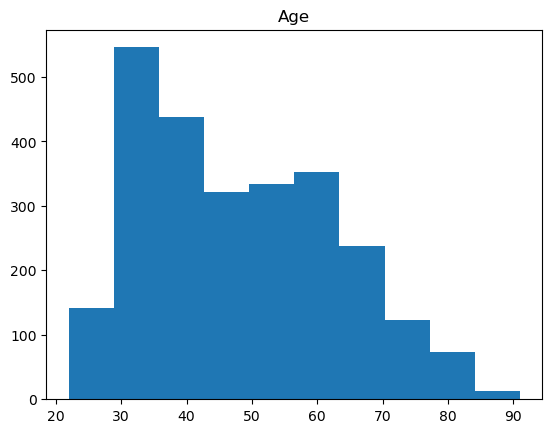

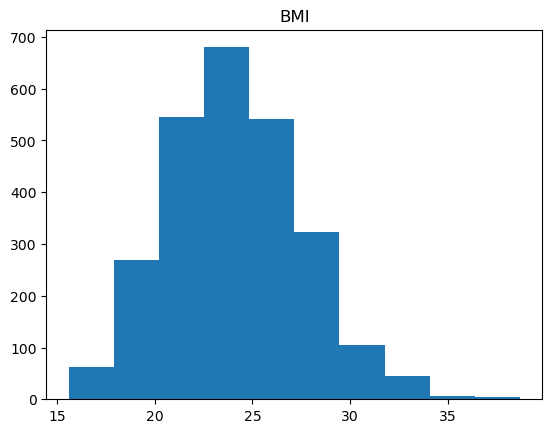

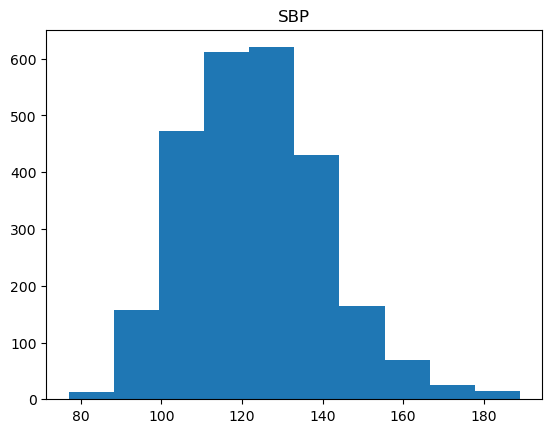

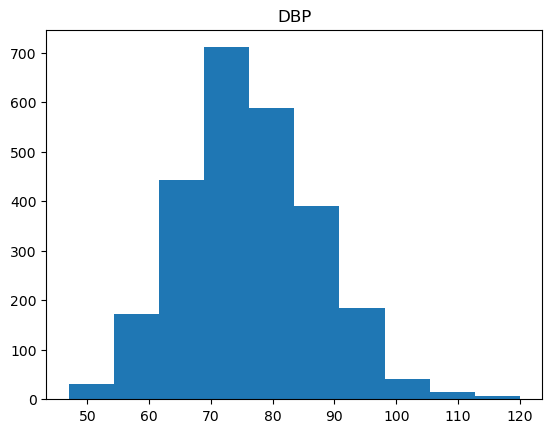

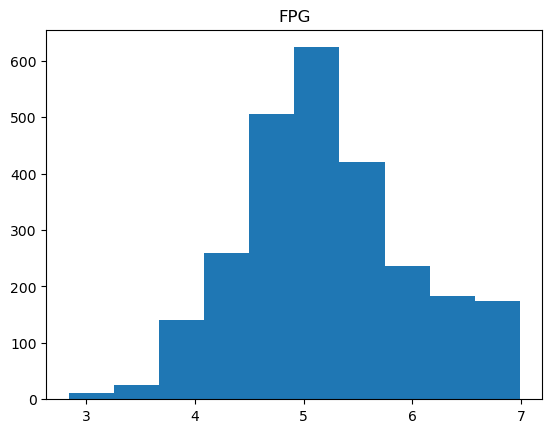

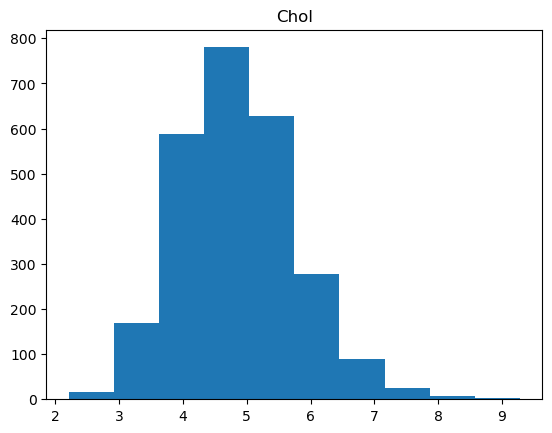

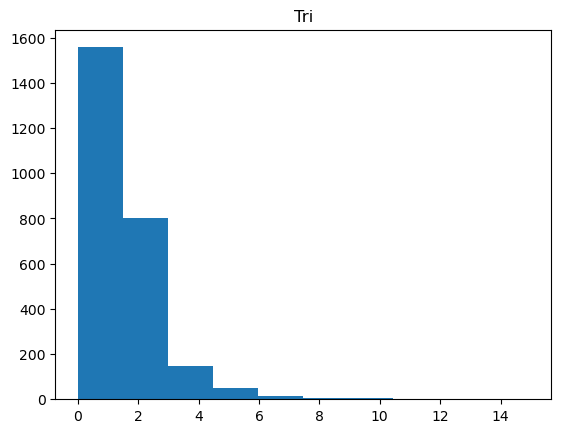

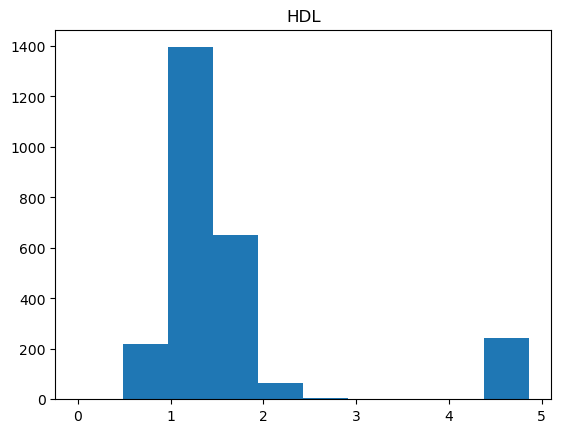

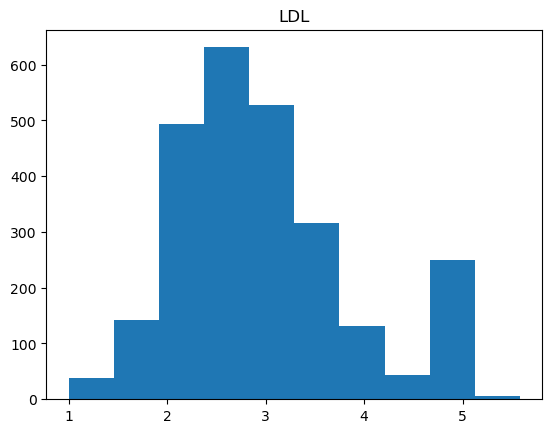

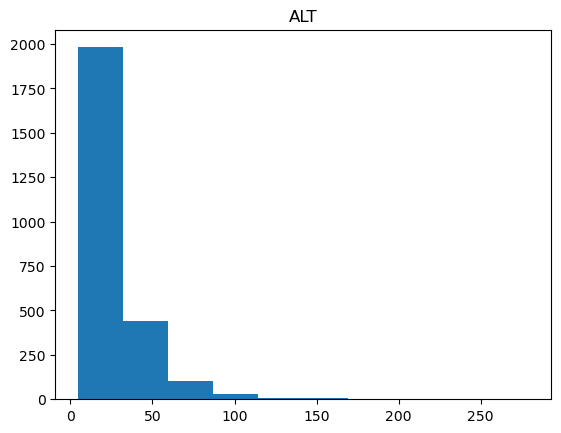

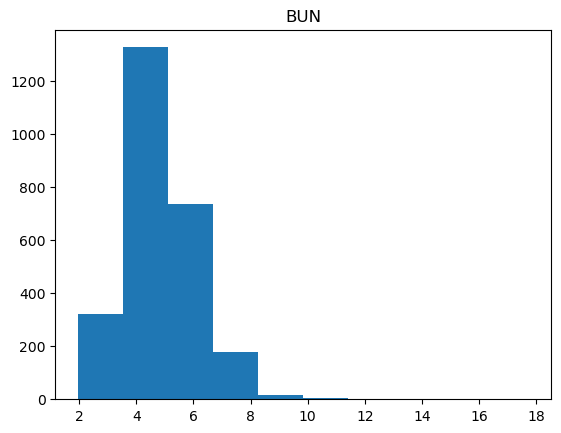

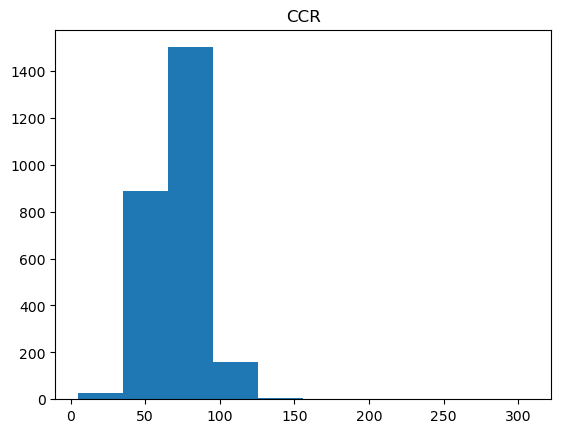

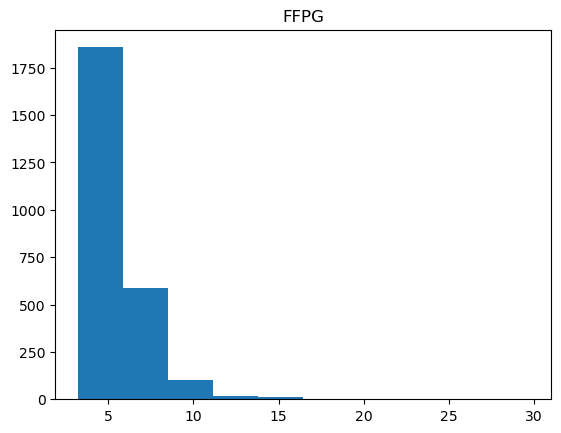

In [8]:
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

<Axes: >

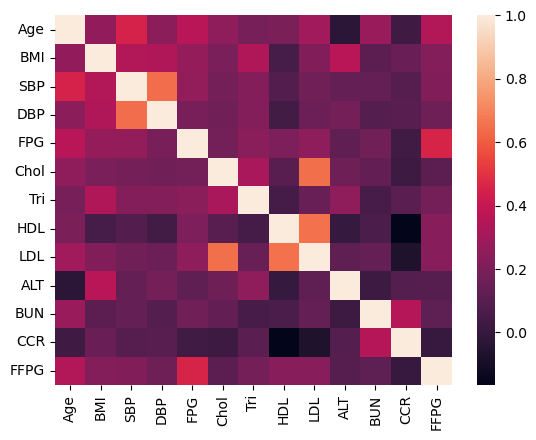

In [9]:
sns.heatmap(df_num.corr())

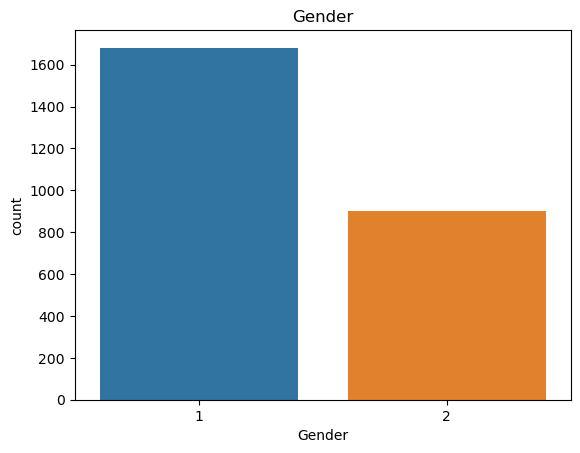

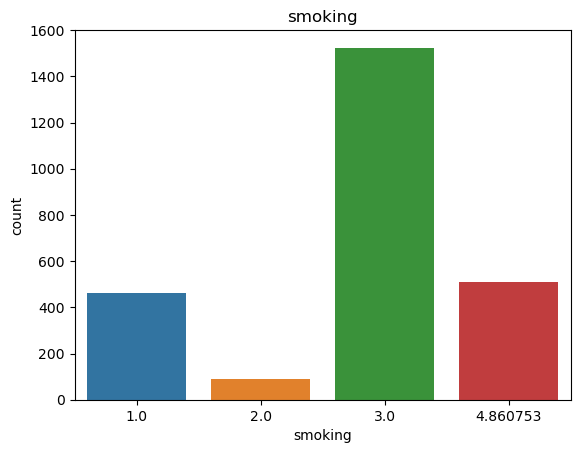

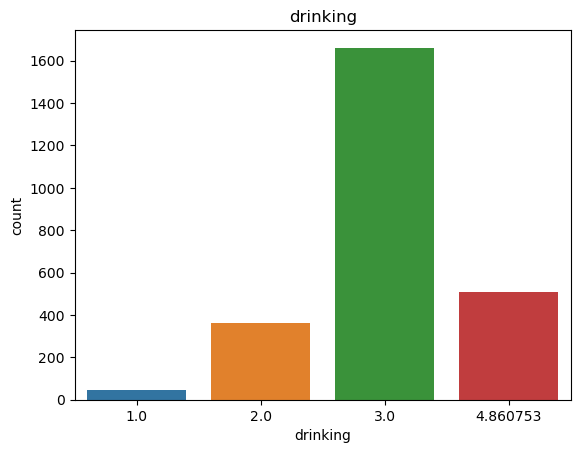

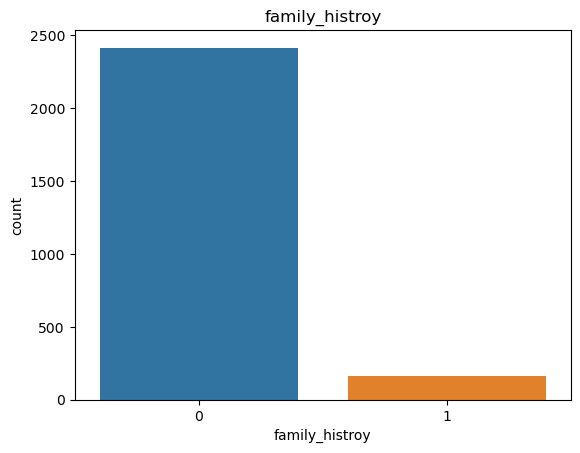

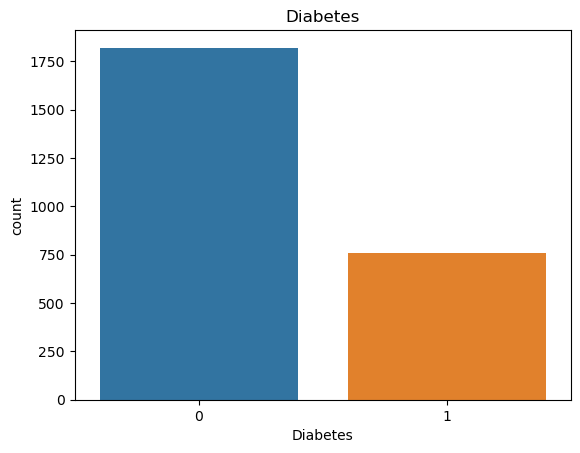

In [10]:
for i in df_cat.columns:
    sns.barplot(x=df_cat[i].value_counts().index,y=df_cat[i].value_counts()).set_title(i)
    plt.show()

In [11]:
#created dummy variables from categories
dummies_1= pd.get_dummies(training[['Age', 'Gender', 'BMI', 'SBP', 'DBP', 'FPG', 'Chol', 'Tri', 'HDL',
       'LDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'smoking', 'drinking',
       'family_histroy', 'Diabetes', 'train_test']])
dummies_2= pd.get_dummies(cv[['Age', 'Gender', 'BMI', 'SBP', 'DBP', 'FPG', 'Chol', 'Tri', 'HDL',
       'LDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'smoking', 'drinking',
       'family_histroy', 'Diabetes', 'train_test']])
dummies_3= pd.get_dummies(test[['Age', 'Gender', 'BMI', 'SBP', 'DBP', 'FPG', 'Chol', 'Tri', 'HDL',
       'LDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'smoking', 'drinking',
       'family_histroy', 'Diabetes', 'train_test']])


#Split to train test again
X_train = dummies_1[dummies_1.train_test == 1].drop(['train_test'], axis =1)
X_cv = dummies_2[dummies_2.train_test == 0].drop(['train_test'], axis =1)
X_test = dummies_3[dummies_3.train_test == 0].drop(['train_test'], axis =1)

y_train = training[training.train_test==1].Diabetes


In [12]:
#scale

scale = StandardScaler()
dummies_1_scaled = dummies_1.copy()
dummies_1_scaled[['Age', 'BMI', 'SBP', 'DBP', 
                  'FPG', 'Chol', 'Tri', 'HDL',
                  'LDL', 'ALT', 'BUN', 'CCR', 
                  'FFPG']]= scale.fit_transform(dummies_1_scaled[['Age', 'BMI', 'SBP', 'DBP', 
                  'FPG', 'Chol', 'Tri', 'HDL',
                  'LDL', 'ALT', 'BUN', 'CCR', 
                  'FFPG']])
dummies_1_scaled

dummies_2_scaled = dummies_2.copy()
dummies_2_scaled[['Age', 'BMI', 'SBP', 'DBP', 
                  'FPG', 'Chol', 'Tri', 'HDL',
                  'LDL', 'ALT', 'BUN', 'CCR', 
                  'FFPG']]= scale.fit_transform(dummies_2_scaled[['Age', 'BMI', 'SBP', 'DBP', 
                  'FPG', 'Chol', 'Tri', 'HDL',
                  'LDL', 'ALT', 'BUN', 'CCR', 
                  'FFPG']])
dummies_2_scaled

dummies_3_scaled = dummies_3.copy()
dummies_3_scaled[['Age', 'BMI', 'SBP', 'DBP', 
                  'FPG', 'Chol', 'Tri', 'HDL',
                  'LDL', 'ALT', 'BUN', 'CCR', 
                  'FFPG']]= scale.fit_transform(dummies_3_scaled[['Age', 'BMI', 'SBP', 'DBP', 
                  'FPG', 'Chol', 'Tri', 'HDL',
                  'LDL', 'ALT', 'BUN', 'CCR', 
                  'FFPG']])
dummies_3_scaled

dummies_1_scaled = dummies_1_scaled[['drinking', 'smoking', 'FFPG', 'FPG', 'HDL', 'Age', 'LDL', 'train_test']]
dummies_2_scaled = dummies_2_scaled[['drinking', 'smoking', 'FFPG', 'FPG', 'HDL', 'Age', 'LDL', 'train_test']]
dummies_3_scaled = dummies_3_scaled[['drinking', 'smoking', 'FFPG', 'FPG', 'HDL', 'Age', 'LDL', 'train_test']]


X_train_scaled = dummies_1_scaled[dummies_1_scaled.train_test == 1].drop(['train_test'], axis =1)
X_cv_scaled = dummies_2_scaled[dummies_2_scaled.train_test == 0].drop(['train_test'], axis =1)
X_test_scaled = dummies_3_scaled[dummies_3_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = training[training.train_test==1].Diabetes
y_cv = cv[cv.train_test==0].Diabetes
y_test = test[test.train_test==0].Diabetes


In [13]:
classifiers = [
    ('GaussianNB', GaussianNB()),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('XGBoost', xgb.XGBClassifier(random_state=42))
]

best_accuracy_dict = {}
best_columns_dict = {}

# Get all possible combinations of 7 columns from X_train_scaled
column_combinations = list(itertools.combinations(X_train_scaled.columns, 7))

# For each classifier, test each combination of 7 columns
for clf_name, clf in classifiers:
    best_accuracy = 0
    best_columns = None

    for columns in column_combinations:
        # Get the indices of the selected columns
        column_indices = [X_train_scaled.columns.get_loc(col) for col in columns]
        
        # Get training data with the selected columns
        X_train_selected = X_train_scaled.iloc[:, column_indices]
        
        # Train the classifier
        clf.fit(X_train_selected, y_train)
        
        # Evaluate the classifier using cross-validation
        cv_accuracy = cross_val_score(clf, X_train_selected, y_train, cv=5, scoring='f1').mean()
        
        # Update the best results if we find a higher accuracy
        if cv_accuracy > best_accuracy:
            best_accuracy = cv_accuracy
            best_columns = columns
    
    # Save the best results for the current classifier
    best_accuracy_dict[clf_name] = best_accuracy
    best_columns_dict[clf_name] = best_columns

# Print the best results for each classifier
for clf_name, clf in classifiers:
    print(f"Best combination of columns for {clf_name}: {best_columns_dict[clf_name]}")
    print(f"Average accuracy for {clf_name}: {best_accuracy_dict[clf_name]}")
    print("------------------------")

Best combination of columns for GaussianNB: ('drinking', 'smoking', 'FFPG', 'FPG', 'HDL', 'Age', 'LDL')
Average accuracy for GaussianNB: 0.9234405855322482
------------------------
Best combination of columns for RandomForest: ('drinking', 'smoking', 'FFPG', 'FPG', 'HDL', 'Age', 'LDL')
Average accuracy for RandomForest: 0.9242029281110631
------------------------
Best combination of columns for XGBoost: ('drinking', 'smoking', 'FFPG', 'FPG', 'HDL', 'Age', 'LDL')
Average accuracy for XGBoost: 0.9263082766026779
------------------------


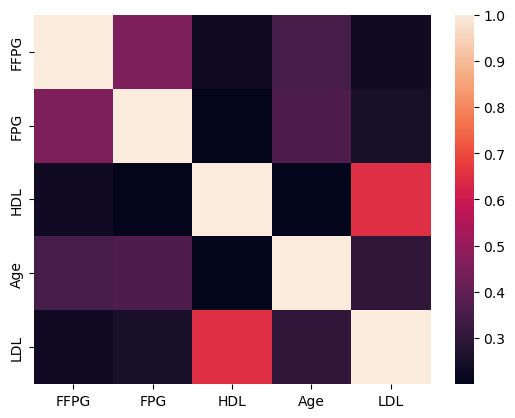

In [14]:
sns.heatmap(df_num[['FFPG', 'FPG', 'HDL', 'Age', 'LDL']].corr())
plt.savefig('heatmap.png') 

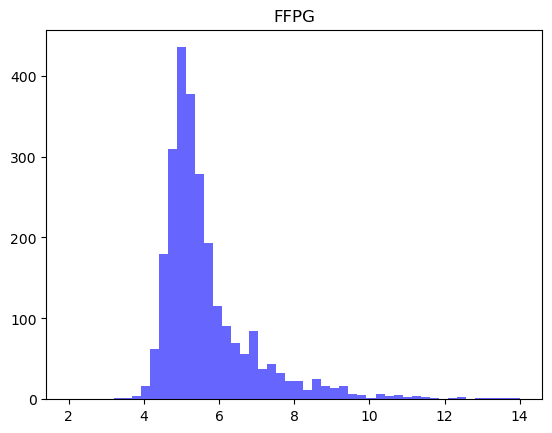

In [15]:
#rescaling FFPG histogram
num_bins = 50

plt.hist(df_num['FFPG'], bins=num_bins, alpha=0.6, color='b', range=(2, 14))
plt.title('FFPG')

plt.savefig(f'FFPGFINAL.png')
plt.show()

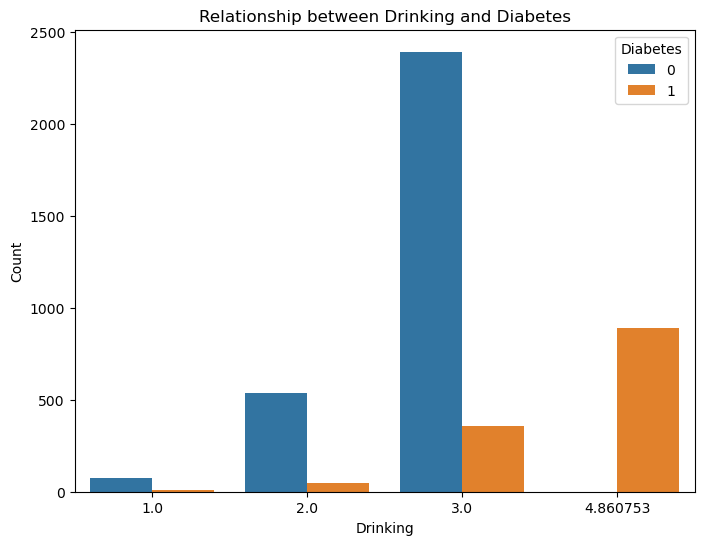

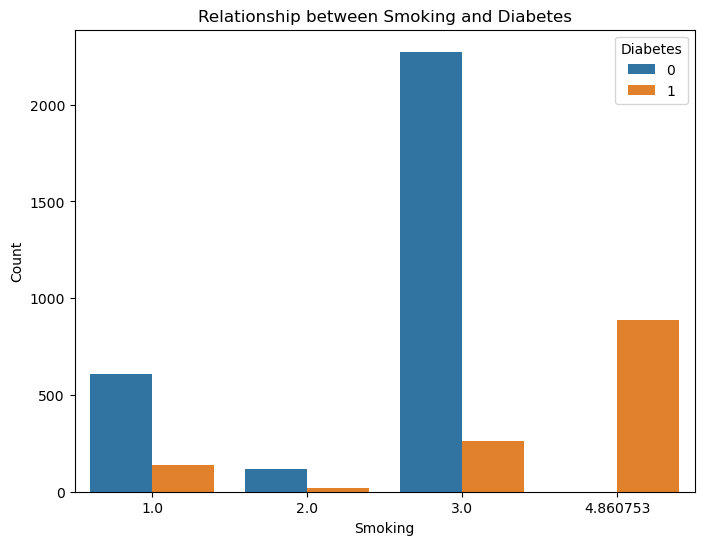

In [16]:
diabetes_variables = ['drinking', 'smoking', 'Diabetes']
diabetes_subset = df[diabetes_variables]


# Bar chart for 'drinking' in relation to diabetes
plt.figure(figsize=(8, 6))
sns.countplot(data=diabetes_subset, x='drinking', hue='Diabetes')
plt.title('Relationship between Drinking and Diabetes')
plt.xlabel('Drinking')
plt.ylabel('Count')
plt.savefig('fig3_drinking.png')
plt.show()

# Bar chart for 'smoking' in relation to diabetes
plt.figure(figsize=(8, 6))
sns.countplot(data=diabetes_subset, x='smoking', hue='Diabetes')
plt.title('Relationship between Smoking and Diabetes')
plt.xlabel('Smoking')
plt.ylabel('Count')
plt.savefig('fig3_smoking.png')
plt.show()


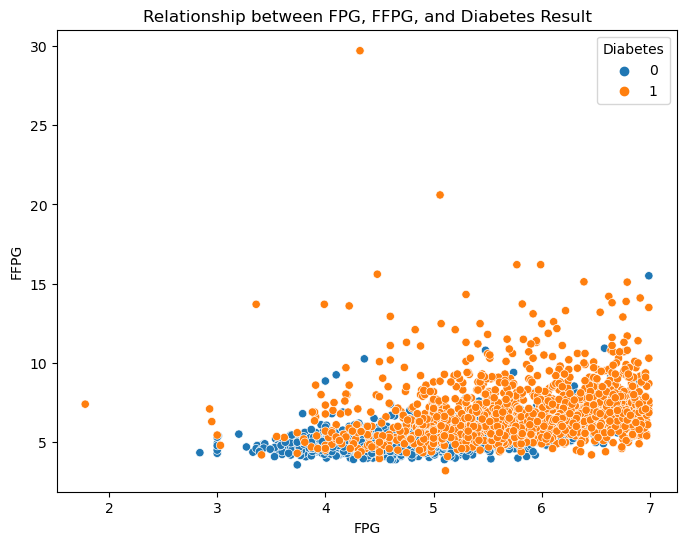

In [17]:
# Select variables related to diabetes
diabetes_variables = ['FPG', 'FFPG', 'Diabetes']
diabetes_subset = df[diabetes_variables]

# Scatterplot for 'HDL' and 'LDL' in relation to diabetes
plt.figure(figsize=(8, 6))
sns.scatterplot(data=diabetes_subset, x='FPG', y='FFPG', hue='Diabetes')
plt.title('Relationship between FPG, FFPG, and Diabetes Result')
plt.xlabel('FPG')
plt.ylabel('FFPG')
plt.savefig('fig2_fpg_ffpg.png') 
plt.show()


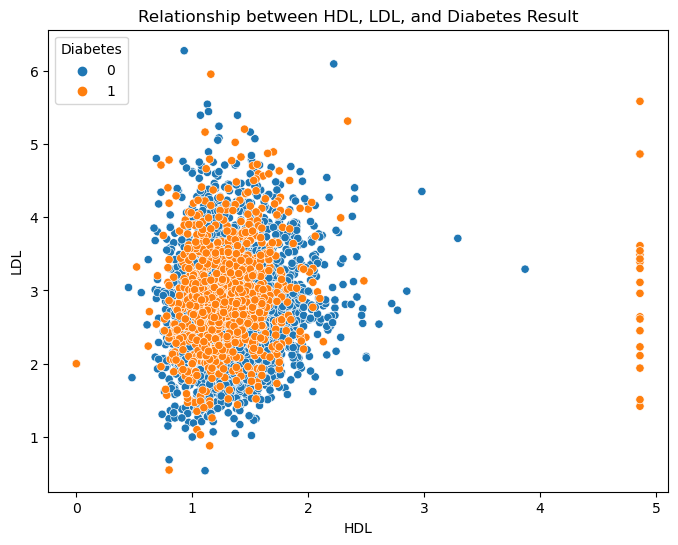

In [18]:
# Select variables related to diabetes
diabetes_variables = ['HDL', 'LDL', 'Diabetes']
diabetes_subset = df[diabetes_variables]

# Scatterplot for 'HDL' and 'LDL' in relation to diabetes
plt.figure(figsize=(8, 6))
sns.scatterplot(data=diabetes_subset, x='HDL', y='LDL', hue='Diabetes')
plt.title('Relationship between HDL, LDL, and Diabetes Result')
plt.xlabel('HDL')
plt.ylabel('LDL')
plt.savefig('fig2_hdl_ldl.png') 
plt.show()


Results for GaussianNB:
Best hyperparameters: {}
Average cross-validation F1 score: 0.9234405855322482
Average training F1 score: 0.9234405855322482
Training F1 score standard deviation: 0.014987208563533753


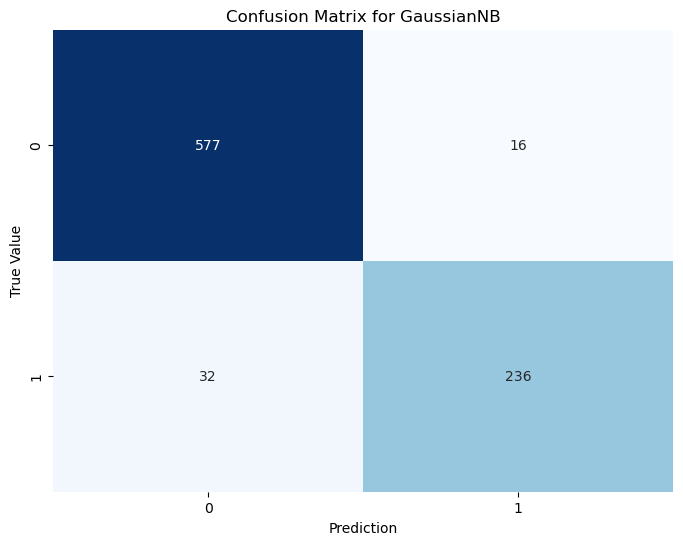

Results on the test set:
Accuracy: 0.9442508710801394
Positive Precision (Precision): 0.9365079365079365
Sensitivity (Recall): 0.8805970149253731
F1 Score: 0.9076923076923077
------------------------
Results for RandomForest:
Best hyperparameters: {'max_depth': None, 'n_estimators': 200}
Average cross-validation F1 score: 0.926712470084612
Average training F1 score: 0.926712470084612
Training F1 score standard deviation: 0.010464711585594037


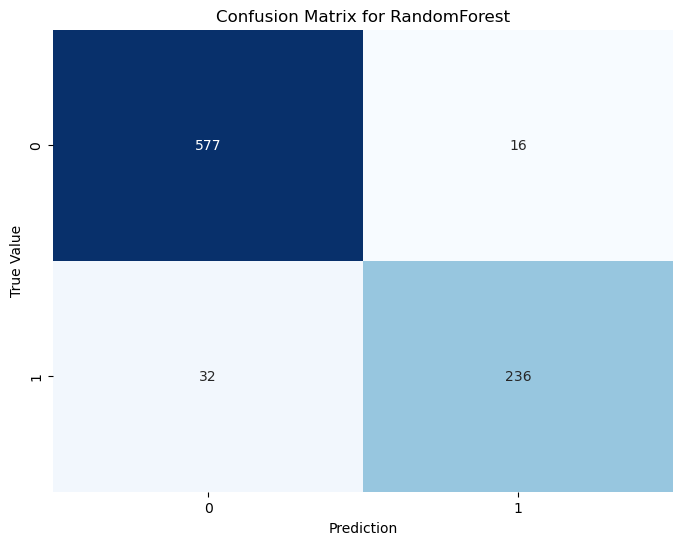

Results on the test set:
Accuracy: 0.9442508710801394
Positive Precision (Precision): 0.9365079365079365
Sensitivity (Recall): 0.8805970149253731
F1 Score: 0.9076923076923077
------------------------
Results for XGBoost:
Best hyperparameters: {'max_depth': 7, 'n_estimators': 50}
Average cross-validation F1 score: 0.9262473304028942
Average training F1 score: 0.9262473304028942
Training F1 score standard deviation: 0.01146941578501706


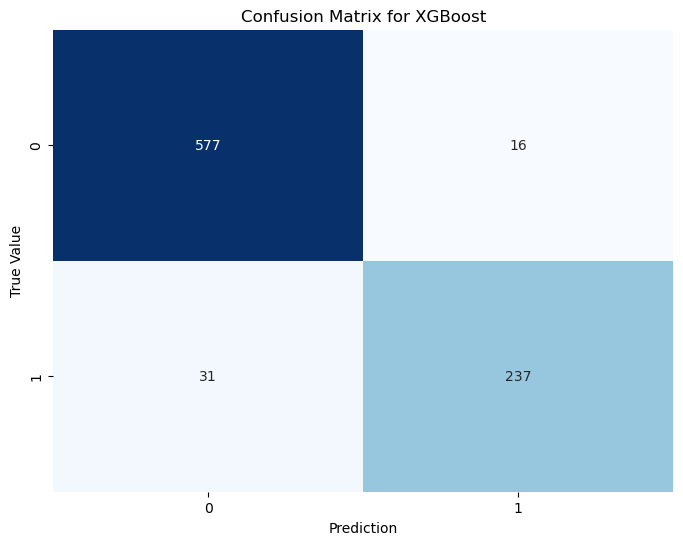

Results on the test set:
Accuracy: 0.9454123112659698
Positive Precision (Precision): 0.9367588932806324
Sensitivity (Recall): 0.8843283582089553
F1 Score: 0.9097888675623801
------------------------
Results for LogisticRegression:
Best hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Average cross-validation F1 score: 0.9154939050320134
Average training F1 score: 0.9154939050320134
Training F1 score standard deviation: 0.019148286711030183


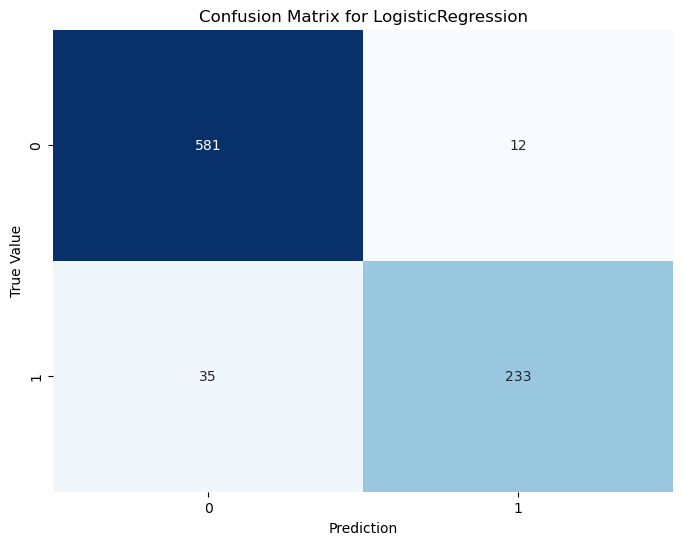

Results on the test set:
Accuracy: 0.9454123112659698
Positive Precision (Precision): 0.9510204081632653
Sensitivity (Recall): 0.8694029850746269
F1 Score: 0.9083820662768032
------------------------
Results for DecisionTree:
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 5}
Average cross-validation F1 score: 0.917110877411049
Average training F1 score: 0.917110877411049
Training F1 score standard deviation: 0.0060932758724506755


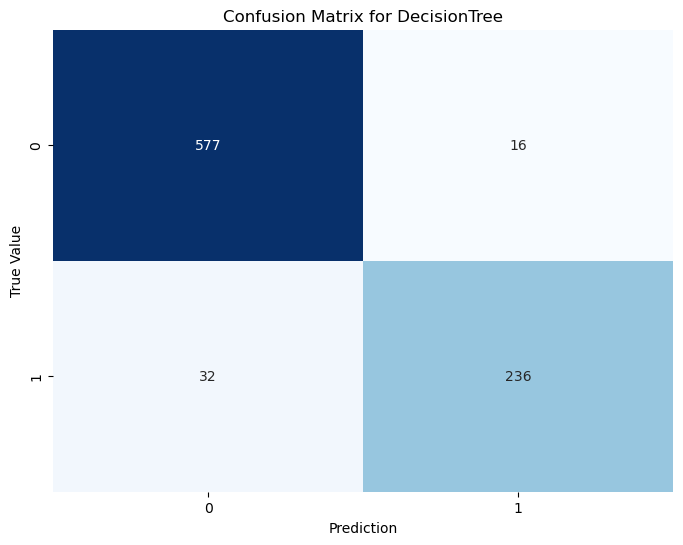

Results on the test set:
Accuracy: 0.9442508710801394
Positive Precision (Precision): 0.9365079365079365
Sensitivity (Recall): 0.8805970149253731
F1 Score: 0.9076923076923077
------------------------
Results for KNeighbors:
Best hyperparameters: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
Average cross-validation F1 score: 0.9213532969940539
Average training F1 score: 0.9213532969940539
Training F1 score standard deviation: 0.021569465070964324


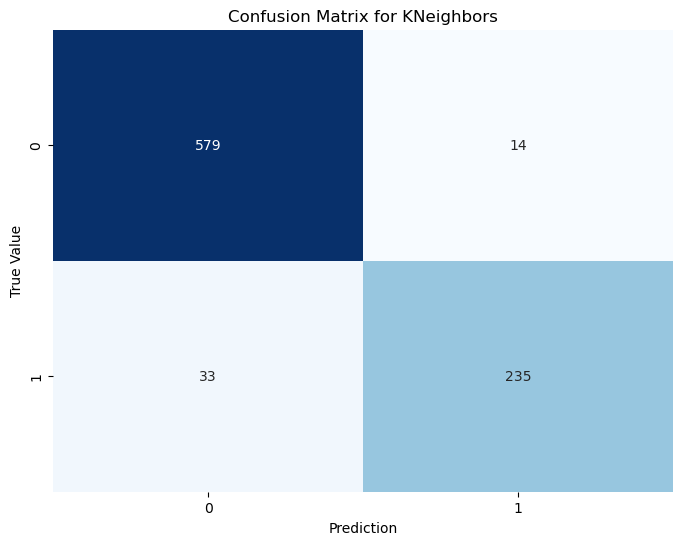

Results on the test set:
Accuracy: 0.9454123112659698
Positive Precision (Precision): 0.9437751004016064
Sensitivity (Recall): 0.8768656716417911
F1 Score: 0.9090909090909091
------------------------
Results for SVC:
Best hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Average cross-validation F1 score: 0.9215131223376538
Average training F1 score: 0.9215131223376538
Training F1 score standard deviation: 0.015299639197578277


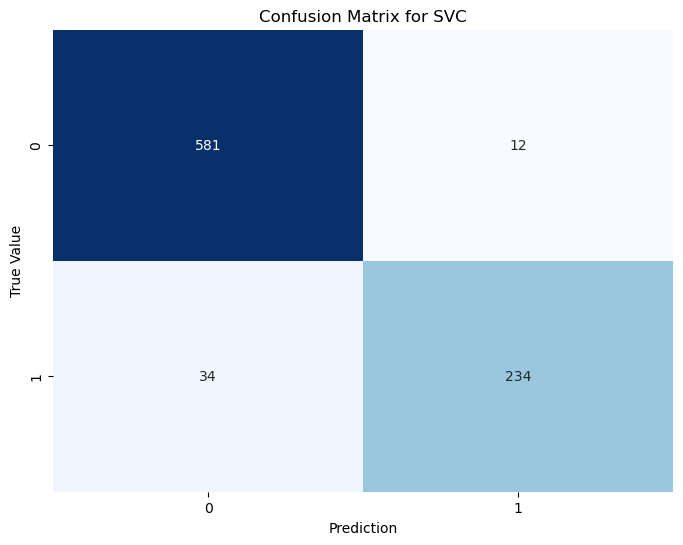

Results on the test set:
Accuracy: 0.9465737514518002
Positive Precision (Precision): 0.9512195121951219
Sensitivity (Recall): 0.8731343283582089
F1 Score: 0.9105058365758755
------------------------


In [19]:
#train the model
classifiers = [
    {
        'name': 'GaussianNB',
        'estimator': GaussianNB(),
        'params': {}
    },
    {
        'name': 'RandomForest',
        'estimator': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20]
        },
        'selector': SelectKBest(score_func=f_classif, k=7)
    },
    {
        'name': 'XGBoost',
        'estimator': xgb.XGBClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7]
        },
        'selector': SelectKBest(score_func=f_classif, k=7)
    },
    {
        'name': 'LogisticRegression',
        'estimator': LogisticRegression(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'lbfgs', 'saga']
        }
    },
    {
        'name': 'DecisionTree',
        'estimator': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    {
        'name': 'KNeighbors',
        'estimator': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
        }
    },
    {
        'name': 'SVC',
        'estimator': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'gamma': ['scale', 'auto']
        }
    }
]

warnings.filterwarnings("ignore")

for clf_data in classifiers:
    clf = clf_data['estimator']
    clf_name = clf_data['name']
    params = clf_data['params']
    selector = clf_data.get('selector')  # Get the selector if it exists

    if selector is not None:
        # Perform feature selection with SelectKBest
        selector.fit(X_train_scaled, y_train)
        X_train_selected = selector.transform(X_train_scaled)
        X_cv_selected = selector.transform(X_cv_scaled)
    else:
        X_train_selected = X_train_scaled
        X_cv_selected = X_cv_scaled

    # Perform hyperparameter tuning on the classifier
    grid_search = GridSearchCV(clf, params, cv=5, scoring='f1')
    grid_search.fit(X_train_selected, y_train)
    
    # Perform cross-validation on the training set
    cv_scores = cross_val_score(grid_search.best_estimator_, X_train_selected, y_train, cv=5, scoring='f1')
    
    # Print the results for the current classifier
    print(f"Results for {clf_name}:")
    print(f"Best hyperparameters: {grid_search.best_params_}")
    print(f"Average cross-validation F1 score: {grid_search.best_score_}")
    print(f"Average training F1 score: {cv_scores.mean()}")
    print(f"Training F1 score standard deviation: {cv_scores.std()}")
    
    # Predict on the test set
    y_pred = grid_search.best_estimator_.predict(X_cv_selected)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_cv, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Prediction')
    plt.ylabel('True Value')
    plt.title(f'Confusion Matrix for {clf_name}')
    plt.show()
    
    # Calculate evaluation metrics on the test set
    accuracy_test = accuracy_score(y_cv, y_pred)
    precision_test = precision_score(y_cv, y_pred)
    recall_test = recall_score(y_cv, y_pred)
    f1_test = f1_score(y_cv, y_pred)
    
    # Print evaluation metrics on the test set
    print(f"Results on the test set:")
    print(f"Accuracy: {accuracy_test}")
    print(f"Positive Precision (Precision): {precision_test}")
    print(f"Sensitivity (Recall): {recall_test}")
    print(f"F1 Score: {f1_test}")
    print("------------------------")
    

In [20]:
param_grids = {
    'GaussianNB': {},  # No hyperparameters to tune
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10]
    },
    'DecisionTree': {  
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'KNeighbors': {  
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    'RandomForest': {  
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20]
    },
    'SVC': {
        'C': [0.01, 0.1, 1, 10]
    },
    'XGBoost': {  
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7]
    }
}

# Iterate over classifiers and perform hyperparameter tuning
for clf_name in param_grids:
    clf_data = next((item for item in classifiers if item["name"] == clf_name), None)
    if clf_data is not None:
        print(f"Performing hyperparameter tuning for {clf_name}...")
        clf = clf_data['estimator']
        param_grid = param_grids[clf_name]
        grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
        grid_search.fit(X_train_selected, y_train)
        
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        
        print("Best hyperparameters:", best_params)
        print("Best F1 Score:", best_score)
        print("------------------------")

Performing hyperparameter tuning for GaussianNB...
Best hyperparameters: {}
Best F1 Score: 0.9234405855322482
------------------------
Performing hyperparameter tuning for LogisticRegression...
Best hyperparameters: {'C': 1}
Best F1 Score: 0.9154939050320134
------------------------
Performing hyperparameter tuning for DecisionTree...
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 5}
Best F1 Score: 0.917110877411049
------------------------
Performing hyperparameter tuning for KNeighbors...
Best hyperparameters: {'n_neighbors': 5, 'weights': 'uniform'}
Best F1 Score: 0.9213532969940539
------------------------
Performing hyperparameter tuning for RandomForest...
Best hyperparameters: {'max_depth': None, 'n_estimators': 200}
Best F1 Score: 0.926712470084612
------------------------
Performing hyperparameter tuning for SVC...
Best hyperparameters: {'C': 10}
Best F1 Score: 0.9215131223376538
------------------------
Performing hyperparameter tuning for XGBoost...
Best hyperp

Performing hyperparameter tuning for GaussianNB...
Best hyperparameters for accuracy: {}
Best accuracy Score: 0.9566108886989639
------------------------
Best hyperparameters for precision: {}
Best precision Score: 0.9616197518863704
------------------------
Best hyperparameters for recall: {}
Best recall Score: 0.8883384932920537
------------------------
Best hyperparameters for f1: {}
Best f1 Score: 0.9234405855322482
------------------------
Performing hyperparameter tuning for LogisticRegression...
Best hyperparameters for accuracy: {'C': 1}
Best accuracy Score: 0.9523503216229589
------------------------
Best hyperparameters for precision: {'C': 0.01}
Best precision Score: 0.9780534218310952
------------------------
Best hyperparameters for recall: {'C': 1}
Best recall Score: 0.8765221878224974
------------------------
Best hyperparameters for f1: {'C': 1}
Best f1 Score: 0.9154939050320134
------------------------
Performing hyperparameter tuning for DecisionTree...
Best hyperpara

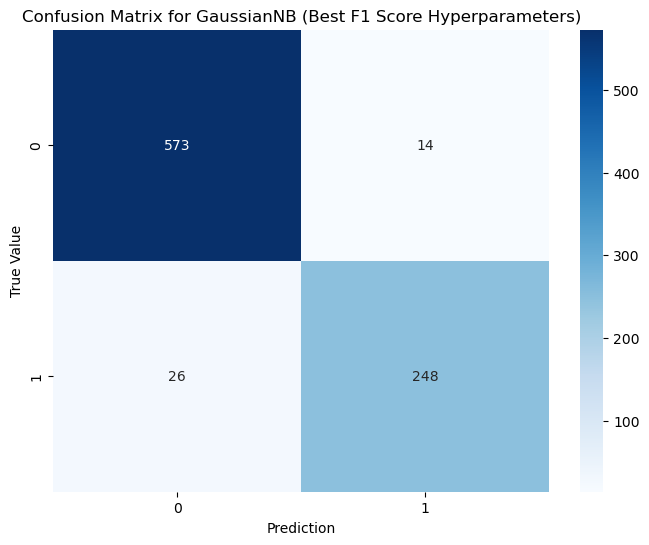

Plotting confusion matrix for LogisticRegression with best F1 Score hyperparameters...


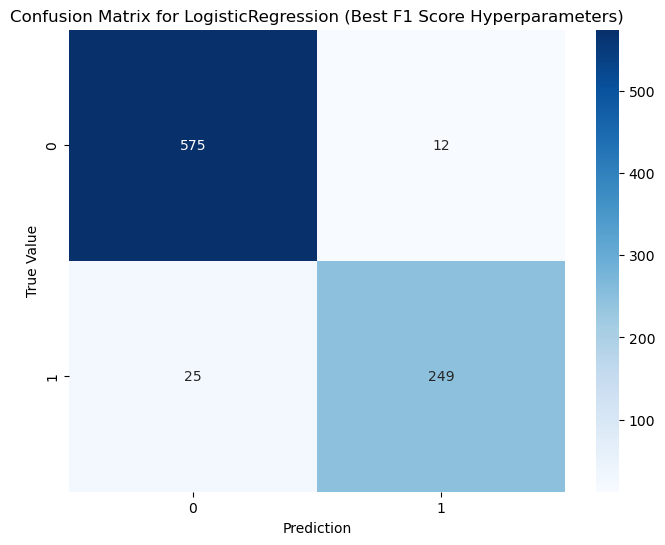

Plotting confusion matrix for DecisionTree with best F1 Score hyperparameters...


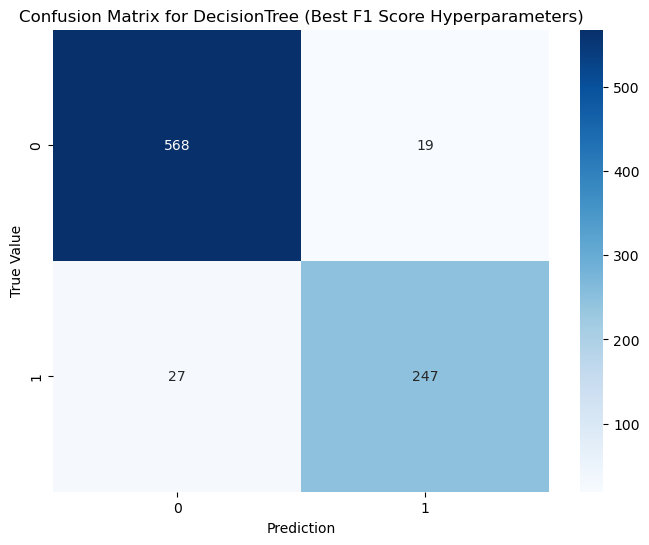

Plotting confusion matrix for KNeighbors with best F1 Score hyperparameters...


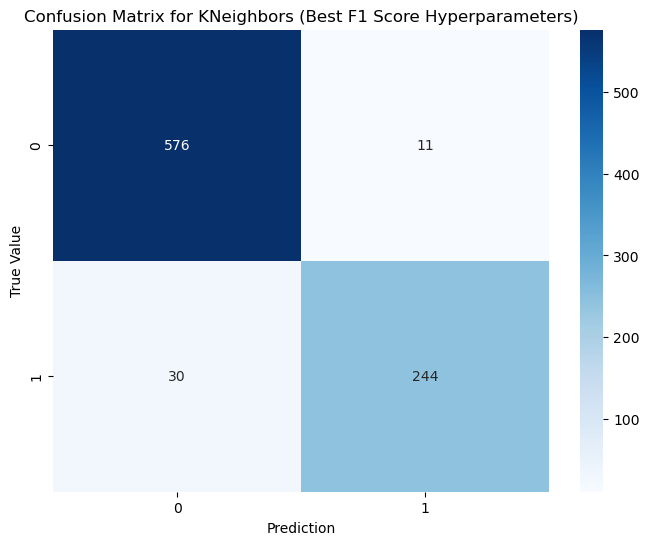

Plotting confusion matrix for RandomForest with best F1 Score hyperparameters...


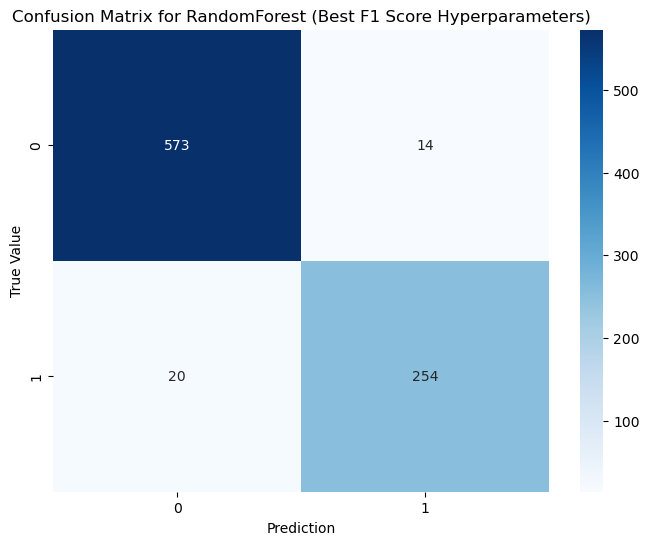

Plotting confusion matrix for SVC with best F1 Score hyperparameters...


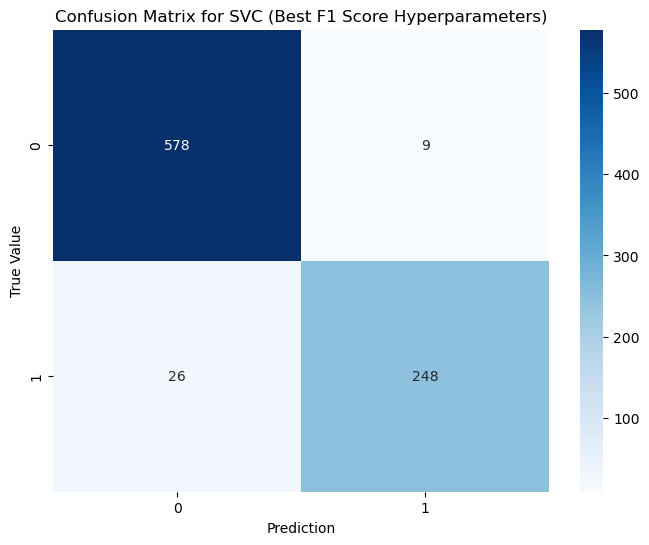

Plotting confusion matrix for XGBoost with best F1 Score hyperparameters...


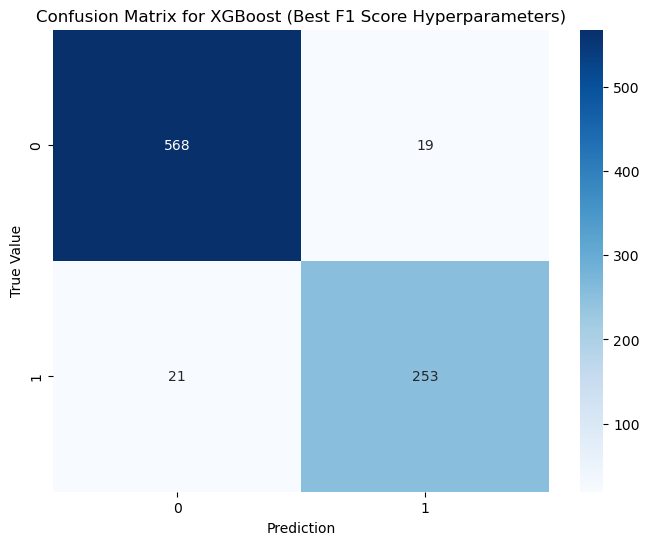

In [21]:
# Initialize dictionaries to store best hyperparameters and scores for each metric
best_params_accuracy = {}
best_params_precision = {}
best_params_recall = {}
best_params_f1 = {}


metrics_to_tune = ['accuracy', 'precision', 'recall', 'f1']

# Iterate over classifiers and perform hyperparameter tuning
for clf_name in param_grids:
    clf_data = next((item for item in classifiers if item["name"] == clf_name), None)
    if clf_data is not None:
        print(f"Performing hyperparameter tuning for {clf_name}...")
        clf = clf_data['estimator']
        param_grid = param_grids[clf_name]
        
        for metric in metrics_to_tune:
            grid_search = GridSearchCV(clf, param_grid, cv=5, scoring=metric)
            grid_search.fit(X_train_selected, y_train)
            
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
            
            print(f"Best hyperparameters for {metric}:", best_params)
            print(f"Best {metric} Score:", best_score)
            
            # Store the best hyperparameters and scores for each metric
            if metric == 'accuracy':
                best_params_accuracy[clf_name] = best_params
            elif metric == 'precision':
                best_params_precision[clf_name] = best_params
            elif metric == 'recall':
                best_params_recall[clf_name] = best_params
            elif metric == 'f1':
                best_params_f1[clf_name] = best_params
            
            print("------------------------")

# Iterate over classifiers and plot confusion matrices for the best F1 Score hyperparameters
for clf_name in param_grids:
    clf_data = next((item for item in classifiers if item["name"] == clf_name), None)
    if clf_data is not None:
        print(f"Plotting confusion matrix for {clf_name} with best F1 Score hyperparameters...")
        clf = clf_data['estimator']
        
        # Determine the best hyperparameters based on F1 Score
        best_hyperparameters = best_params_f1[clf_name]
        
        # Set the classifier with the best hyperparameters
        clf.set_params(**best_hyperparameters)
        
        # Train the classifier on the training set
        clf.fit(X_train_scaled, y_train)
        
        # Perform predictions on the test data using the classifier with the best hyperparameters
        y_pred = clf.predict(X_test_scaled)
        
        # Calculate the confusion matrix
        confusion_matrix_result = confusion_matrix(y_test, y_pred)
        
        # Create a heatmap for the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Prediction')
        plt.ylabel('True Value')
        plt.title(f'Confusion Matrix for {clf_name} (Best F1 Score Hyperparameters)')
        plt.savefig(f'confusion_matrix_{clf_name}.png')
        plt.show()

Metrics on test data:
Accuracy: 0.9581881533101045
Precision: 0.9541984732824428
Recall: 0.9124087591240876
F1 Score: 0.9328358208955224


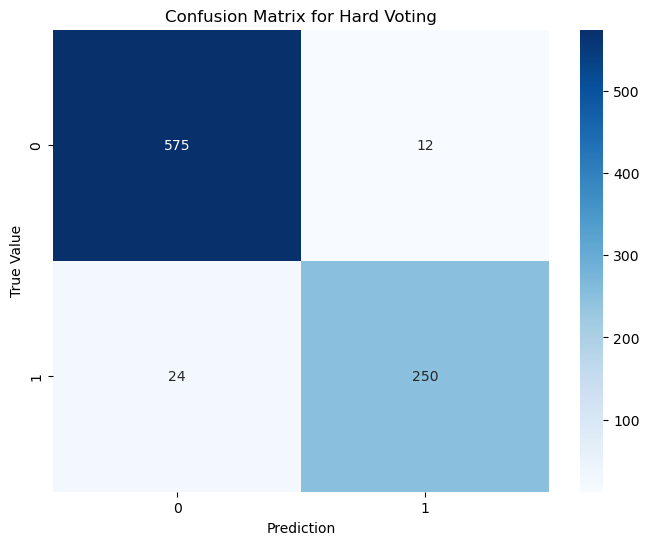

In [22]:

# Define individual classifiers with their hyperparameters
clf_naive_bayes = GaussianNB()
clf_logistic_regression = LogisticRegression(max_iter=1000, random_state=42)
clf_decision_tree = DecisionTreeClassifier(random_state=42)
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_random_forest = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=None)
clf_svc = SVC(probability=True, random_state=42)
clf_xgboost = xgb.XGBClassifier(random_state=42, n_estimators=50, max_depth=7)

# Create the VotingClassifier with Hard Voting
voting_clf_hard = VotingClassifier(
    estimators=[
        ('naive_bayes', clf_naive_bayes),
        ('logistic_regression', clf_logistic_regression),
        ('decision_tree', clf_decision_tree),
        ('knn', clf_knn),
        ('random_forest', clf_random_forest),
        ('svc', clf_svc),
        ('xgboost', clf_xgboost)
    ],
    voting='hard'  
)

# Train the VotingClassifier with Hard Voting on the training set
voting_clf_hard.fit(X_train_scaled, y_train)

# Predict on the validation set using Hard Voting
y_pred_hard = voting_clf_hard.predict(X_cv_scaled)

# Calculate evaluation metrics on the validation set for Hard Voting
accuracy_hard = accuracy_score(y_cv, y_pred_hard)
precision_hard = precision_score(y_cv, y_pred_hard)
recall_hard = recall_score(y_cv, y_pred_hard)
f1_hard = f1_score(y_cv, y_pred_hard)

# Perform predictions on the test data using the Hard Voting ensemble
y_pred_hard_test = voting_clf_hard.predict(X_test_scaled)

# Calculate evaluation metrics on the test data
accuracy_test = accuracy_score(y_test, y_pred_hard_test)
precision_test = precision_score(y_test, y_pred_hard_test)
recall_test = recall_score(y_test, y_pred_hard_test)
f1_test = f1_score(y_test, y_pred_hard_test)

# Print the metrics on the test data
print("Metrics on test data:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)

# Perform predictions on the test data using the Hard Voting ensemble
y_pred_hard_test = voting_clf_hard.predict(X_test_scaled)

# Calculate the confusion matrix
confusion_matrix_result = confusion_matrix(y_test, y_pred_hard_test)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('True Value')
plt.title('Confusion Matrix for Hard Voting')
plt.show()

Metrics on test data for Soft Voting:
Accuracy: 0.959349593495935
Precision: 0.9543726235741445
Recall: 0.916058394160584
F1 Score: 0.9348230912476724


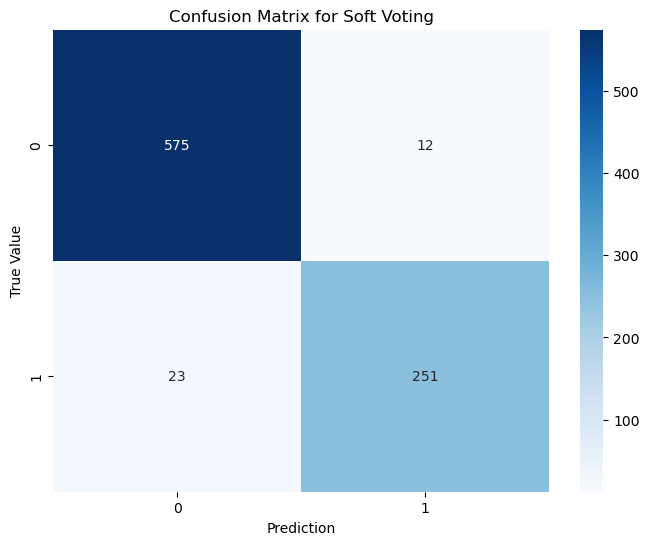

In [23]:
# Create the VotingClassifier with Soft Voting
voting_clf_soft = VotingClassifier(
    estimators=[
        ('naive_bayes', clf_naive_bayes),
        ('logistic_regression', clf_logistic_regression),
        ('decision_tree', clf_decision_tree),
        ('knn', clf_knn),
        ('random_forest', clf_random_forest),
        ('svc', clf_svc),
        ('xgboost', clf_xgboost)
    ],
    voting='soft'  # Use Soft Voting
)

# Train the VotingClassifier with Soft Voting on the training set
voting_clf_soft.fit(X_train_scaled, y_train)

# Predict on the validation set using Soft Voting
y_pred_soft = voting_clf_soft.predict(X_cv_scaled)

# Calculate evaluation metrics on the validation set for Soft Voting
accuracy_soft = accuracy_score(y_cv, y_pred_soft)
precision_soft = precision_score(y_cv, y_pred_soft)
recall_soft = recall_score(y_cv, y_pred_soft)
f1_soft = f1_score(y_cv, y_pred_soft)

# Perform predictions on the test data using the Soft Voting ensemble
y_pred_soft_test = voting_clf_soft.predict(X_test_scaled)

# Calculate evaluation metrics on the test data
accuracy_test_soft = accuracy_score(y_test, y_pred_soft_test)
precision_test_soft = precision_score(y_test, y_pred_soft_test)
recall_test_soft = recall_score(y_test, y_pred_soft_test)
f1_test_soft = f1_score(y_test, y_pred_soft_test)

# Print the metrics on the test data for Soft Voting
print("Metrics on test data for Soft Voting:")
print("Accuracy:", accuracy_test_soft)
print("Precision:", precision_test_soft)
print("Recall:", recall_test_soft)
print("F1 Score:", f1_test_soft)

# Calculate the confusion matrix for Soft Voting
confusion_matrix_result_soft = confusion_matrix(y_test, y_pred_soft_test)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result_soft, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('True Value')
plt.title('Confusion Matrix for Soft Voting')
plt.show()

In [24]:


# Scale your data (if not already scaled)
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train_scaled)
X_cv_scaled = scale.transform(X_cv_scaled)
X_test_scaled = scale.transform(X_test_scaled)

# Define the FNN model
model_fnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with additional metrics like Precision and Recall
model_fnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Train the model
model_fnn.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_cv_scaled, y_cv))

# Predict on the test set
y_pred = model_fnn.predict(X_test_scaled)

# Convert predictions to binary labels
y_pred_binary = (y_pred > 0.50).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

history = model_fnn.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_cv_scaled, y_cv))
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Calculate the probability of positive class for the Precision-Recall Curve
y_prob_positive = model_fnn.predict(X_test_scaled)

# Calculate the Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_positive)

# Calculate the Area Under the Precision-Recall Curve (AUC-PR)
auc_pr = auc(recall, precision)

# Calculate the Youden's Index
youden_index = recall + precision - 1

# Find the threshold that maximizes the Youden's Index
best_threshold = np.argmax(youden_index)

# Calculate the ROC AUC metric
roc_auc = roc_auc_score(y_test, y_pred)

# Calculate the confusion matrix
confusion_matrix_result = confusion_matrix(y_test, y_pred_binary)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision_score(y_test, y_pred_binary))
print("Recall:", recall_score(y_test, y_pred_binary))
print("F1-score:", f1_score(y_test, y_pred_binary))
print("ROC AUC:", roc_auc_score(y_test, y_prob_positive))
print("AUC-PR:", auc_pr)
print("Optimal threshold according to Youden's Index:", best_threshold / len(y_pred_binary))
print("Confusion Matrix:")
print(confusion_matrix_result)

Epoch 1/10
81/81 [==============================] - 2s 12ms/step - loss: 0.3456 - accuracy: 0.9148 - precision: 0.8700 - recall: 0.8357 - val_loss: 0.1847 - val_accuracy: 0.9350 - val_precision: 0.9417 - val_recall: 0.8433
Epoch 2/10
81/81 [==============================] - 0s 5ms/step - loss: 0.1479 - accuracy: 0.9520 - precision: 0.9480 - recall: 0.8857 - val_loss: 0.1583 - val_accuracy: 0.9454 - val_precision: 0.9402 - val_recall: 0.8806
Epoch 3/10
81/81 [==============================] - 0s 5ms/step - loss: 0.1291 - accuracy: 0.9539 - precision: 0.9521 - recall: 0.8883 - val_loss: 0.1525 - val_accuracy: 0.9489 - val_precision: 0.9409 - val_recall: 0.8918
Epoch 4/10
81/81 [==============================] - 0s 5ms/step - loss: 0.1228 - accuracy: 0.9562 - precision: 0.9551 - recall: 0.8936 - val_loss: 0.1497 - val_accuracy: 0.9501 - val_precision: 0.9310 - val_recall: 0.9067
Epoch 5/10
81/81 [==============================] - 0s 5ms/step - loss: 0.1190 - accuracy: 0.9566 - precision: 

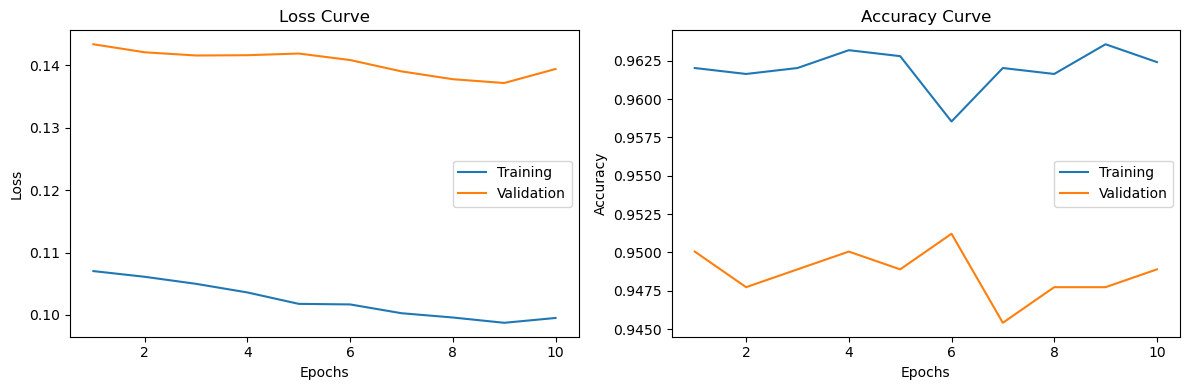

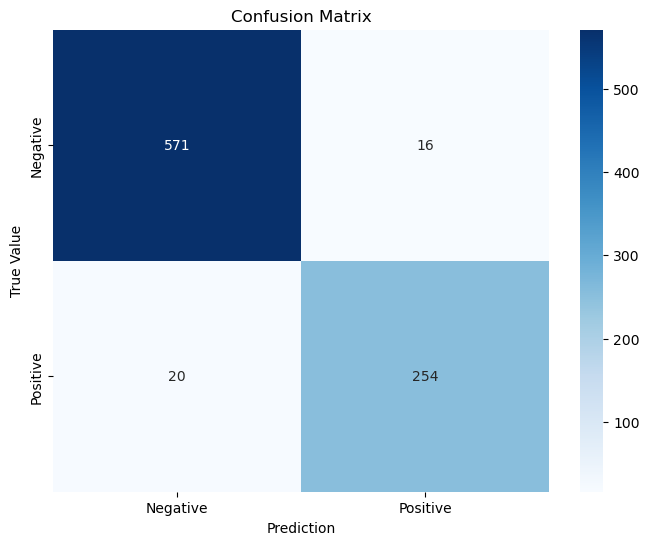

In [25]:
epochs = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training')
plt.plot(epochs, val_accuracy, label='Validation')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Define class labels
class_labels = ["Negative", "Positive"]  # Replace with appropriate labels

# Create a figure for the confusion matrix plot
plt.figure(figsize=(8, 6))

# Use seaborn to create a heatmap of the confusion matrix
sns.heatmap(confusion_matrix_result, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Prediction')
plt.ylabel('True Value')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [26]:
# Define the FNN model with L1 and L2 regularization
model_fnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l1(0.01), activity_regularizer=l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l1(0.01), activity_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid', kernel_regularizer=l1(0.01), activity_regularizer=l2(0.01))
])

# Compile the model with additional metrics such as Precision and Recall
model_fnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

# Train the model
model_fnn.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_cv_scaled, y_cv))

# Predict on the test set
y_pred = model_fnn.predict(X_test_scaled)

# Convert predictions to binary labels
y_pred_binary = (y_pred > 0.50).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

history = model_fnn.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_cv_scaled, y_cv))
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Calculate the probability of the positive class for the Precision-Recall Curve
y_prob_positive = model_fnn.predict(X_test_scaled)

# Calculate the Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_positive)

# Calculate the area under the Precision-Recall Curve (AUC-PR)
auc_pr = auc(recall, precision)

# Calculate the Youden Index
youden_index = recall + precision - 1

# Find the threshold that maximizes the Youden Index
best_threshold = np.argmax(youden_index)

# Calculate the AUC-ROC metric
roc_auc = roc_auc_score(y_test, y_pred)

# Calculate the confusion matrix
confusion_matrix_result = confusion_matrix(y_test, y_pred_binary)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision_score(y_test, y_pred_binary))
print("Recall:", recall_score(y_test, y_pred_binary))
print("F1-score:", f1_score(y_test, y_pred_binary))
print("ROC AUC:", roc_auc_score(y_test, y_prob_positive))
print("AUC-PR:", auc_pr)
print("Optimal threshold according to the Youden Index:", best_threshold / len(y_pred_binary))
print("Confusion Matrix:")
print(confusion_matrix_result)

Epoch 1/10
81/81 [==============================] - 4s 17ms/step - loss: 3.1491 - accuracy: 0.8764 - precision_1: 0.8932 - recall_1: 0.6597 - auc: 0.8997 - val_loss: 2.3320 - val_accuracy: 0.9396 - val_precision_1: 0.9821 - val_recall_1: 0.8209 - val_auc: 0.9634
Epoch 2/10
81/81 [==============================] - 0s 5ms/step - loss: 1.7469 - accuracy: 0.9399 - precision_1: 0.9779 - recall_1: 0.8147 - auc: 0.9713 - val_loss: 1.2412 - val_accuracy: 0.9384 - val_precision_1: 0.9736 - val_recall_1: 0.8246 - val_auc: 0.9745
Epoch 3/10
81/81 [==============================] - 0s 5ms/step - loss: 0.9220 - accuracy: 0.9434 - precision_1: 0.9812 - recall_1: 0.8239 - auc: 0.9782 - val_loss: 0.6942 - val_accuracy: 0.9384 - val_precision_1: 0.9864 - val_recall_1: 0.8134 - val_auc: 0.9768
Epoch 4/10
81/81 [==============================] - 0s 5ms/step - loss: 0.6000 - accuracy: 0.9380 - precision_1: 0.9870 - recall_1: 0.8003 - auc: 0.9791 - val_loss: 0.5422 - val_accuracy: 0.9361 - val_precision_1:

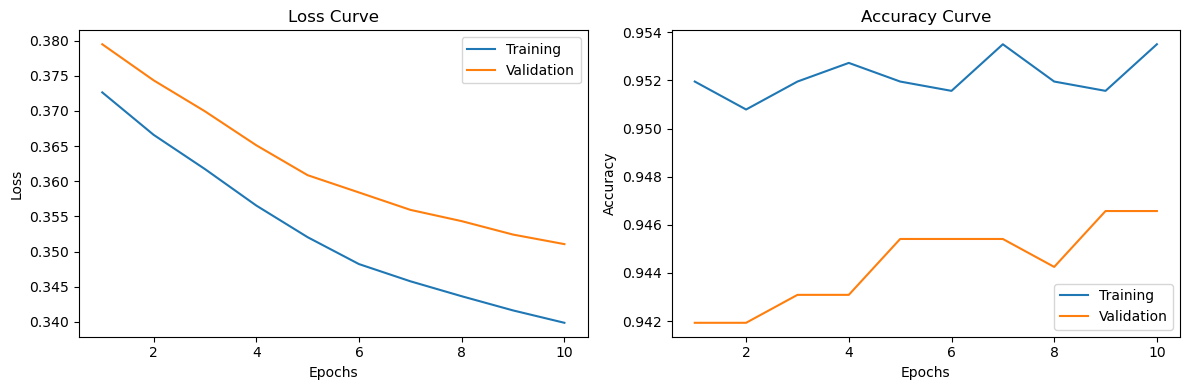

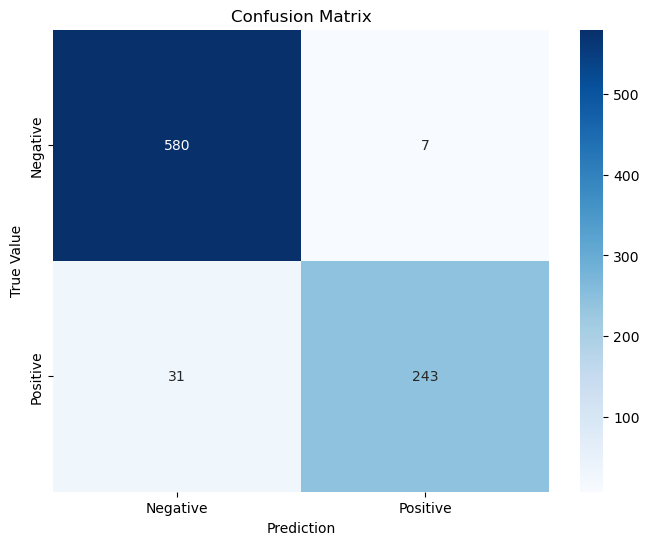

In [27]:
# Loss and accuracy curves
epochs = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training')
plt.plot(epochs, val_accuracy, label='Validation')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Define class labels
class_labels = ["Negative", "Positive"]  # Replace with appropriate labels

# Create a figure for the confusion matrix plot
plt.figure(figsize=(8, 6))

# Use seaborn to create a heatmap of the confusion matrix
sns.heatmap(confusion_matrix_result, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Prediction')
plt.ylabel('True Value')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

27/27 [==============================] - 0s 2ms/step  

27/27 [==============================] - 0s 2ms/step                             

27/27 [==============================] - 0s 2ms/step                             

27/27 [==============================] - 0s 2ms/step                             

27/27 [==============================] - 0s 2ms/step                             

27/27 [==============================] - 0s 2ms/step                             

27/27 [==============================] - 0s 2ms/step                             

27/27 [==============================] - 0s 3ms/step                             

27/27 [==============================] - 0s 3ms/step                             

27/27 [==============================] - 0s 2ms/step                             

27/27 [==============================] - 0s 4ms/step                              

27/27 [==============================] - 0s 2ms/step                              

27/27 [======================

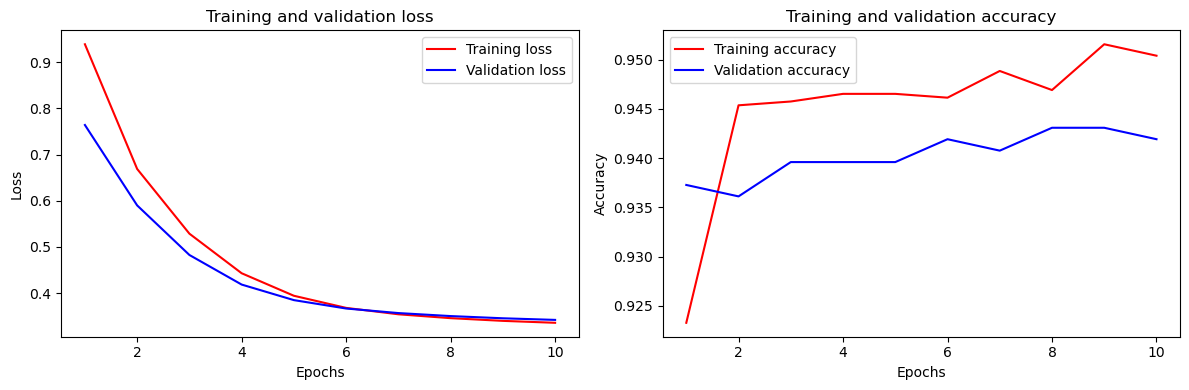

In [28]:

# Define the objective function for hyperparameter optimization
def objective(params):
    # Define the FNN model with suggested hyperparameters
    model_fnn = Sequential()
    model_fnn.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l1(params['l1_reg']), activity_regularizer=l2(params['l2_reg'])))
    for _ in range(params['num_hidden_layers']):
        model_fnn.add(Dense(params['hidden_layer_units'], activation='relu', kernel_regularizer=l1(params['l1_reg']), activity_regularizer=l2(params['l2_reg'])))
        model_fnn.add(Dropout(params['dropout_rate']))
    model_fnn.add(Dense(1, activation='sigmoid', kernel_regularizer=l1(params['l1_reg']), activity_regularizer=l2(params['l2_reg'])))

    # Compile the model with additional metrics like Precision and Recall
    model_fnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

    # Train the model
    history = model_fnn.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(X_cv_scaled, y_cv))

    # Calculate AUC-PR on the test set
    y_prob_positive = model_fnn.predict(X_test_scaled)
    precision, recall, _ = precision_recall_curve(y_test, y_prob_positive)
    auc_pr = auc(recall, precision)

    return {'loss': -auc_pr, 'status': STATUS_OK}

# Define the hyperparameter search space
space = {
    'num_hidden_layers': hp.choice('num_hidden_layers', [1, 2, 3]),
    'hidden_layer_units': hp.quniform('hidden_layer_units', 32, 128, 1),
    'dropout_rate': hp.uniform('dropout_rate', 0.0, 0.5),
    'l1_reg': hp.loguniform('l1_reg', -5, -1),
    'l2_reg': hp.loguniform('l2_reg', -5, -1)
}

# Initialize the Trials object for tracking
trials = Trials()

# Perform hyperparameter optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# Print the best hyperparameters found
print("Best hyperparameters:", best)

# Plot the evolution of metrics per epoch at the end of optimization
best_trial = trials.best_trial
best_params = best_trial['misc']['vals']
best_params = {key: best_params[key][0] for key in best_params}
best_model = Sequential()
best_model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l1(best_params['l1_reg']), activity_regularizer=l2(best_params['l2_reg'])))
for _ in range(best_params['num_hidden_layers']):
    best_model.add(Dense(best_params['hidden_layer_units'], activation='relu', kernel_regularizer=l1(best_params['l1_reg']), activity_regularizer=l2(best_params['l2_reg'])))
    best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l1(best_params['l1_reg']), activity_regularizer=l2(best_params['l2_reg'])))
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
history = best_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(X_cv_scaled, y_cv))

# Access training and validation metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the evolution of metrics per epoch
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/10
81/81 [==============================] - 3s 14ms/step - loss: 1.0093 - accuracy: 0.8481 - precision_103: 0.8758 - recall_103: 0.5650 - auc_102: 0.8597 - val_loss: 0.8104 - val_accuracy: 0.9361 - val_precision_103: 0.9692 - val_recall_103: 0.8209 - val_auc_102: 0.9654
Epoch 2/10
81/81 [==============================] - 0s 4ms/step - loss: 0.7141 - accuracy: 0.9376 - precision_103: 0.9615 - recall_103: 0.8213 - auc_102: 0.9681 - val_loss: 0.6332 - val_accuracy: 0.9361 - val_precision_103: 0.9776 - val_recall_103: 0.8134 - val_auc_102: 0.9719
Epoch 3/10
81/81 [==============================] - 0s 4ms/step - loss: 0.5704 - accuracy: 0.9438 - precision_103: 0.9738 - recall_103: 0.8318 - auc_102: 0.9748 - val_loss: 0.5198 - val_accuracy: 0.9384 - val_precision_103: 0.9778 - val_recall_103: 0.8209 - val_auc_102: 0.9754
Epoch 4/10
81/81 [==============================] - 0s 4ms/step - loss: 0.4771 - accuracy: 0.9446 - precision_103: 0.9769 - recall_103: 0.8318 - auc_102: 0.9780 - va

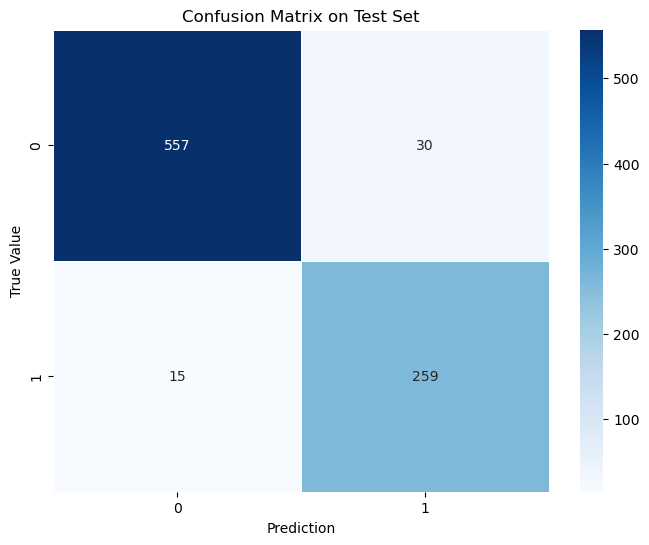

Metrics on Test Set:
Accuracy: 0.9477351916376306
Precision: 0.8961937716262975
Recall: 0.9452554744525548
F1-score: 0.9200710479573713
ROC AUC: 0.9873910394309803


In [29]:
# Best hyperparameters found
best_hyperparameters = {
    'num_hidden_layers': best['num_hidden_layers'],
    'hidden_layer_units': best['hidden_layer_units'],
    'dropout_rate': best['dropout_rate'],
    'l1_reg': best['l1_reg'],
    'l2_reg': best['l2_reg']
}

# Define and build the FNN model with the optimal hyperparameters
best_model_fnn = Sequential()
best_model_fnn.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l1(best_hyperparameters['l1_reg']), activity_regularizer=l2(best_hyperparameters['l2_reg'])))
for _ in range(best_hyperparameters['num_hidden_layers']):
    best_model_fnn.add(Dense(int(best_hyperparameters['hidden_layer_units']), activation='relu', kernel_regularizer=l1(best_hyperparameters['l1_reg']), activity_regularizer=l2(best_hyperparameters['l2_reg'])))
    best_model_fnn.add(Dropout(best_hyperparameters['dropout_rate']))
best_model_fnn.add(Dense(1, activation='sigmoid', kernel_regularizer=l1(best_hyperparameters['l1_reg']), activity_regularizer=l2(best_hyperparameters['l2_reg'])))

# Compile the model with additional metrics like Precision and Recall
best_model_fnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

# Train the model with the optimal hyperparameters
history_best = best_model_fnn.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_cv_scaled, y_cv))

# Predict on the test set with the optimal model
y_pred_test = best_model_fnn.predict(X_test_scaled)

# Convert predictions to binary labels
y_pred_binary_test = (y_pred_test > 0.24).astype(int)

# Calculate metrics on the test set
accuracy_test = accuracy_score(y_test, y_pred_binary_test)
precision_test = precision_score(y_test, y_pred_binary_test)
recall_test = recall_score(y_test, y_pred_binary_test)
f1_test = f1_score(y_test, y_pred_binary_test)

# Calculate ROC AUC on the test set
roc_auc_test = roc_auc_score(y_test, y_pred_test)

# Calculate the confusion matrix on the test set
confusion_matrix_test = confusion_matrix(y_test, y_pred_binary_test)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_test, annot=True, fmt="d", cmap="Blues", linewidths=.5)
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Prediction")
plt.ylabel("True Value")
plt.show()

# Print metrics on the test set
print("Metrics on Test Set:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_test)
print("ROC AUC:", roc_auc_test)

Epoch 1/10
81/81 [==============================] - 3s 17ms/step - loss: 1.0427 - accuracy: 0.8036 - precision_117: 0.6317 - recall_117: 0.8003 - auc_116: 0.9010 - val_loss: 0.8303 - val_accuracy: 0.9326 - val_precision_117: 0.9070 - val_recall_117: 0.8731 - val_auc_116: 0.9595
Epoch 2/10
81/81 [==============================] - 0s 5ms/step - loss: 0.7190 - accuracy: 0.9423 - precision_117: 0.9322 - recall_117: 0.8673 - auc_116: 0.9689 - val_loss: 0.6295 - val_accuracy: 0.9431 - val_precision_117: 0.9544 - val_recall_117: 0.8582 - val_auc_116: 0.9682
Epoch 3/10
81/81 [==============================] - 0s 5ms/step - loss: 0.5618 - accuracy: 0.9450 - precision_117: 0.9585 - recall_117: 0.8502 - auc_116: 0.9740 - val_loss: 0.5100 - val_accuracy: 0.9431 - val_precision_117: 0.9582 - val_recall_117: 0.8545 - val_auc_116: 0.9730
Epoch 4/10
81/81 [==============================] - 1s 9ms/step - loss: 0.4653 - accuracy: 0.9492 - precision_117: 0.9744 - recall_117: 0.8502 - auc_116: 0.9780 - va

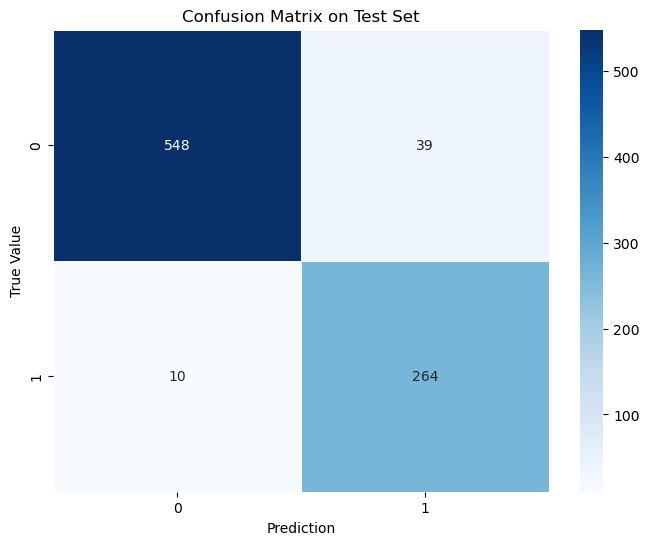

Metrics on Test Set:
Accuracy: 0.943089430894309
Precision: 0.8712871287128713
Recall: 0.9635036496350365
F1-score: 0.9150779896013865
ROC AUC: 0.987335082505378


In [43]:
# Best hyperparameters found
best_hyperparameters = {
    'num_hidden_layers': best['num_hidden_layers'],
    'hidden_layer_units': best['hidden_layer_units'],
    'dropout_rate': best['dropout_rate'],
    'l1_reg': best['l1_reg'],
    'l2_reg': best['l2_reg']
}

# Define and build the FNN model with the optimal hyperparameters
best_model_fnn = Sequential()
best_model_fnn.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l1(best_hyperparameters['l1_reg']), activity_regularizer=l2(best_hyperparameters['l2_reg'])))
for _ in range(best_hyperparameters['num_hidden_layers']):
    best_model_fnn.add(Dense(int(best_hyperparameters['hidden_layer_units']), activation='relu', kernel_regularizer=l1(best_hyperparameters['l1_reg']), activity_regularizer=l2(best_hyperparameters['l2_reg'])))
    best_model_fnn.add(Dropout(best_hyperparameters['dropout_rate']))
best_model_fnn.add(Dense(1, activation='sigmoid', kernel_regularizer=l1(best_hyperparameters['l1_reg']), activity_regularizer=l2(best_hyperparameters['l2_reg'])))

# Compile the model with additional metrics like Precision and Recall
best_model_fnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

# Train the model with the optimal hyperparameters
history_best = best_model_fnn.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_cv_scaled, y_cv))

# Predict on the test set with the optimal model
y_pred_test = best_model_fnn.predict(X_test_scaled)

# Convert predictions to binary labels
y_pred_binary_test = (y_pred_test > 0.21).astype(int)

# Calculate metrics on the test set
accuracy_test = accuracy_score(y_test, y_pred_binary_test)
precision_test = precision_score(y_test, y_pred_binary_test)
recall_test = recall_score(y_test, y_pred_binary_test)
f1_test = f1_score(y_test, y_pred_binary_test)

# Calculate ROC AUC on the test set
roc_auc_test = roc_auc_score(y_test, y_pred_test)

# Calculate the confusion matrix on the test set
confusion_matrix_test = confusion_matrix(y_test, y_pred_binary_test)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_test, annot=True, fmt="d", cmap="Blues", linewidths=.5)
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Prediction")
plt.ylabel("True Value")
plt.show()

# Print metrics on the test set
print("Metrics on Test Set:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_test)
print("ROC AUC:", roc_auc_test)